In [1]:
from py2neo import Graph
import matplotlib.pyplot as plt
from tabulate import tabulate

In [3]:
graph = Graph(
    "bolt://localhost:7687",
    auth=("neo4j", "admin"),
    # name="neo4j-2",
)

In [11]:
def plot_distribution(data, show_labels=False):
    plt.bar(data.keys(), data.values())
    if not show_labels:
        plt.xticks([])

def plot_ratings_distribution(show_labels):
    results = graph.run("""
        match (u:User)-[r:RATES]-(m:Movie)
        return r.rating as rating, count(r) as count order by r.rating
    """).data()
    ratings_dict = { rat["rating"]: rat["count"] for rat in results }
    plot_distribution(ratings_dict, show_labels=show_labels)

def plot_ratings_per_user_distribution(show_labels):
    results = graph.run("""
        MATCH (u:User)-[r:RATES]-(m)
        with u, count(r) as counter
        return u.username as username, counter order by counter desc;
    """).data()
    ratings_dict = { rat["username"]: rat["counter"] for rat in results }
    plot_distribution(ratings_dict, show_labels=show_labels)

def plot_ratings_per_movie_distribution(show_labels):
    results = graph.run("""
        MATCH (u:User)-[r:RATES]-(m)
        WITH m, count(r) as counter
        RETURN m.id as id, counter order by counter desc;
    """).data()
    ratings_dict = { rat["id"]: rat["counter"] for rat in results }
    plot_distribution(ratings_dict, show_labels=show_labels)

def count_graph():
    movies = graph.run("match (m:Movie) return count(m)").evaluate()
    users = graph.run("match (u:User) return count(u)").evaluate()
    ratings = graph.run("match (u:User)-[r:RATES]-(m:Movie) return count(r)").evaluate()
    average_ratings_per_user = graph.run("""
        MATCH (u:User)
        WITH u, size((u)-[:RATES]-()) as rateCount
        RETURN avg(rateCount) as averageRateCount
    """).evaluate()
    average_ratings_per_movie = graph.run("""
        MATCH (m:Movie)
        WITH m, size((m)-[:RATES]-()) as rateCount
        RETURN avg(rateCount) as averageRateCount
    """).evaluate()
    print(tabulate([[
        movies,
        users,
        ratings,
        average_ratings_per_movie,
        average_ratings_per_user
    ]], headers=["Movies", "Users", "Ratings", "Average ratings per movie", "Average ratings per user"]))


def delete_movies_with_less_than_n_ratings(n):
    graph.run(f"""
        MATCH (m:Movie)
        WITH m, size((m)-[:RATES]-()) as rateCount
        WHERE rateCount < {n}
        DETACH DELETE m
    """)

def get_graph_statistics(show_labels):
    plot_ratings_distribution(show_labels=show_labels)
    count_graph()


### The 100K version of the graph

  Movies    Users    Ratings    Average ratings per movie    Average ratings per user
--------  -------  ---------  ---------------------------  --------------------------
    9067      672      99802                      11.0072                     148.515


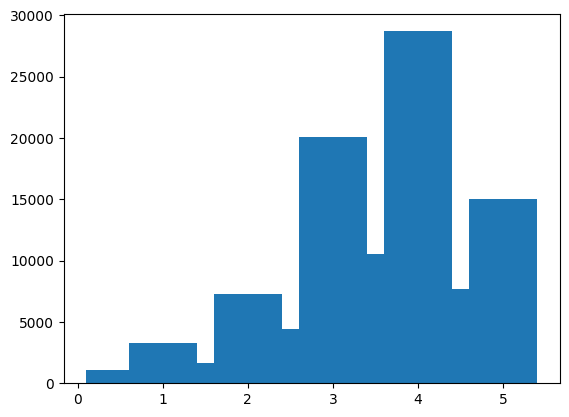

In [5]:
get_graph_statistics(show_labels=True)

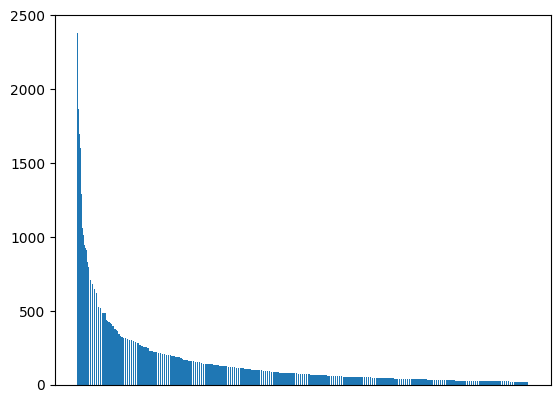

In [6]:
plot_ratings_per_user_distribution(show_labels=False)

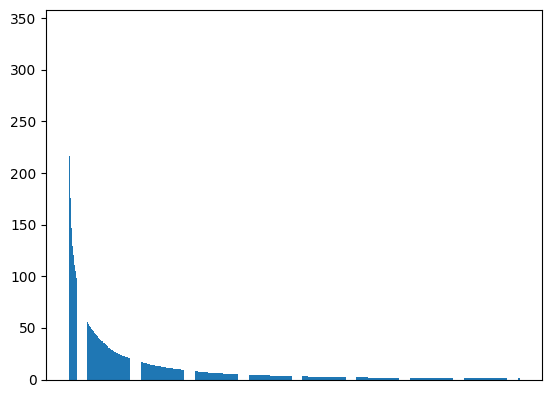

In [7]:
plot_ratings_per_movie_distribution(show_labels=False)

### Delete movies with less than 5 ratings

In [15]:
delete_movies_with_less_than_n_ratings(5)

  Movies    Users    Ratings    Average ratings per movie    Average ratings per user
--------  -------  ---------  ---------------------------  --------------------------
    3485      672      89932                      25.8055                     133.827


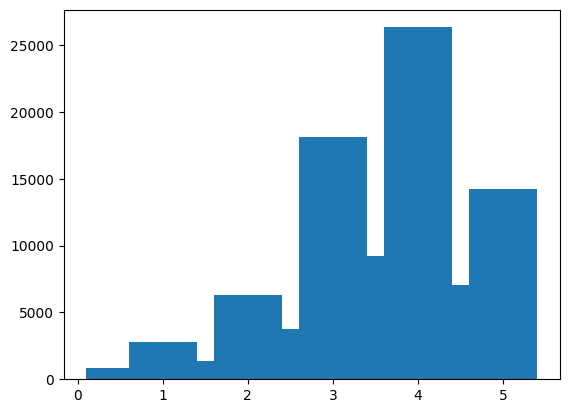

In [16]:
get_graph_statistics(show_labels=True)

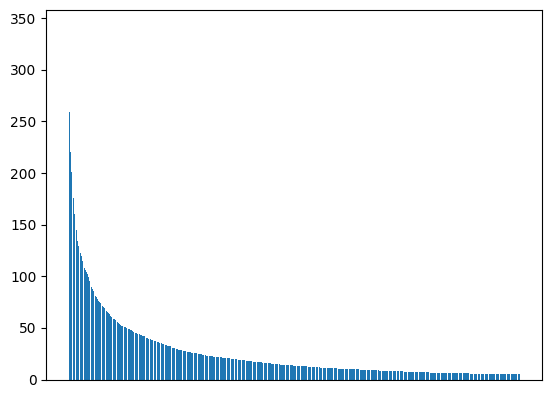

In [17]:
plot_ratings_per_movie_distribution(show_labels=False)

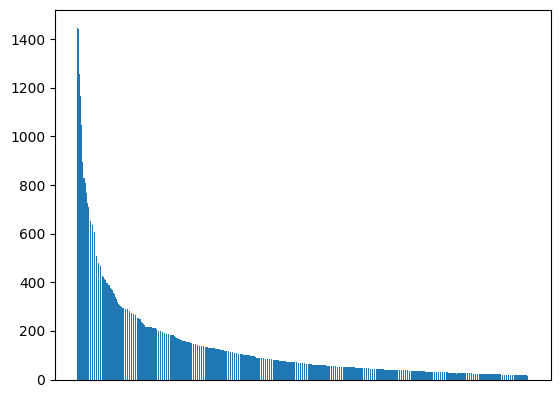

In [18]:
plot_ratings_per_user_distribution(show_labels=False)